<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Tokenization
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Pretrained Tokenizers
  </div> 


  <div style="
      font-size: 15px; 
      line-height: 12px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Jean-baptiste AUJOGUE
  </div> 

  
  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  December 2022
  </div>

<a id="plan"></a>

***
<div style="font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Table of Content
  </div> 


#### References

- Huggingface Tokenizers [Quicktour](https://huggingface.co/docs/tokenizers/quicktour)
- Huggingface Tokenizers [Summary of tokenizers](https://huggingface.co/docs/transformers/tokenizer_summary)
- Huggingface Tokenizers [Tokenizer pipeline quicktour](https://huggingface.co/docs/tokenizers/pipeline)
- Huggingface Tokenizers [Overview notebook](https://github.com/huggingface/notebooks/blob/main/examples/tokenizer_training.ipynb)
- Huggingface Tokenizers [Course](https://huggingface.co/learn/nlp-course/chapter6/1?fw=pt) and [Course notebooks](https://github.com/huggingface/course/blob/main/chapters/en/chapter6)
- Huggingface Tokenizers [Github repository](https://github.com/huggingface/tokenizers)

<div style="font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Packages
  </div> 

In [1]:
import os
import pandas as pd

# auto
from tokenizers import Tokenizer
from transformers import AutoTokenizer

# pretokenizers
from tokenizers.pre_tokenizers import Whitespace

# base tokenizers
from tokenizers.models import (
    BPE,
    Unigram,
    WordLevel,
    WordPiece,
) 
# base tokenizer trainers
from tokenizers.trainers import (
    BpeTrainer,
    UnigramTrainer,
    WordLevelTrainer,
    WordPieceTrainer,
)
# other special tokenizers, see the list at 
# https://github.com/huggingface/tokenizers/tree/master/bindings/python/py_src/tokenizers/implementations
from tokenizers.implementations import (
    CharBPETokenizer,          # The original BPE
    ByteLevelBPETokenizer,     # The byte level version of the BPE
    SentencePieceBPETokenizer, # A BPE implementation compatible with the one used by SentencePiece
    BertWordPieceTokenizer,    # The famous Bert tokenizer, using WordPiece
) 

C:\Users\jb\miniconda3\envs\bert-playground\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id="tokenizers"></a>

In [89]:
text = "Hello, y'all! How are you 😁? I introduce a triple   and a quadruple    space 🤗."

### Remark on the `tokenizers.Tokenizer` vs. `transformers.AutoTokenizer` classes

`tokenizers.Tokenizer` provides the base utility class for all tokenizers of huggingface models. However, many models have specific logic appart from pure tokenization, which is cast into a model-specific class. Such class does not belong to the general purpose `tokenizers` library, but rather to the broad `transformers` library which contains both model-agnostic and model-specific classes and functions. When instanciating a tokenizer from the transformer.AutoTokenizer class, we can always recover the underlying `tokenizers.Tokenizer` object as an attribute `_tokenizer`, which should be accessed using the `backend_tokenizer` property, see the `transformers`  [documentation](https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils_fast.py), as the following example shows:

In [93]:
model_id = 'mistralai/Mistral-7B-Instruct-v0.2'
tokenizer = AutoTokenizer.from_pretrained(model_id)

type(tokenizer), type(tokenizer.backend_tokenizer)

(transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast,
 tokenizers.Tokenizer)

In the content below we describe the behavior of instances of `tokenizers.Tokenizer`. However, in the case the instance derives from an instance of `transformers.AutoTokenizer`, this behavior is typically not supposed to be used directly, and should instead be replaced by the direct use of the `transformers.AutoTokenizer instance.

Whenever you want to train a new tokenizer based on same parameters than an existing one, the approach depends on whether the instance comes from `tokenizers.Tokenizer` or `transformers.AutoTokenizer`. We detail here the former case, while in the latter case the `train_new_from_iterator` method should be used.

# 1 Byte Pair Encoding

[Back to top](#plan)


[Byte-Pair Encoding (BPE)](https://huggingface.co/docs/transformers/tokenizer_summary#byte-pair-encoding-bpe) was introduced in [Neural Machine Translation of Rare Words with Subword Units (Sennrich et al., 2015)](https://arxiv.org/abs/1508.07909). BPE relies on a pre-tokenizer that splits the training data into words. Pretokenization can be as simple as space tokenization, e.g. GPT-2, RoBERTa. More advanced pre-tokenization include rule-based tokenization, e.g. XLM, FlauBERT which uses Moses for most languages, or GPT which uses spaCy and ftfy, to count the frequency of each word in the training corpus.

After pre-tokenization, a set of unique words has been created and the frequency with which each word occurred in the training data has been determined. Next, BPE creates a base vocabulary consisting of all symbols that occur in the set of unique words and learns merge rules to form a new symbol from two symbols of the base vocabulary. It does so until the vocabulary has attained the desired vocabulary size. Note that the desired vocabulary size is a hyperparameter to define before training the tokenizer.

A base vocabulary that includes all possible base characters can be quite large if e.g. all unicode characters are considered as base characters. To have a better base vocabulary, GPT-2 uses bytes as the base vocabulary, which is a clever trick to force the base vocabulary to be of size 256 while ensuring that every base character is included in the vocabulary. With some additional rules to deal with punctuation, the GPT2’s tokenizer can tokenize every text without the need for the <unk> symbol. GPT-2 has a vocabulary size of 50,257, which corresponds to the 256 bytes base tokens, a special end-of-text token and the symbols learned with 50,000 merges.
    


## 1.1 Use pretrained tokenizer


In [94]:
# make your choice between the 2
# bpe_tokenizer = Tokenizer.from_pretrained('gpt2')
bpe_tokenizer = AutoTokenizer.from_pretrained(model_id).backend_tokenizer

type(bpe_tokenizer.model)

tokenizers.models.BPE

<Axes: ylabel='Frequency'>

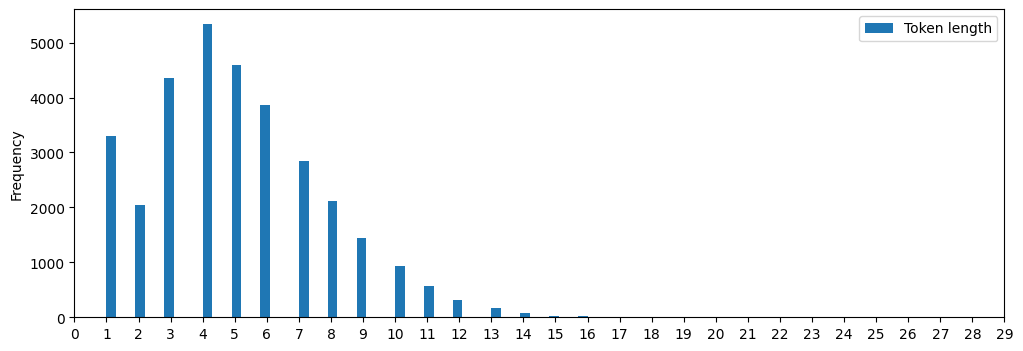

In [84]:
pd.DataFrame(map(len, bpe_tokenizer.get_vocab()), columns = ['Token length']).plot.hist(bins = 50, xticks = list(range(30)), figsize = (12, 4))

In [85]:
bpe_tokenizer.get_vocab_size()

32000

In [95]:
output = bpe_tokenizer.encode(text)
tokens = [t for t in output.tokens]
offsets = [output.offsets[i] for i in range(len(output))]
spans  = [text[s:e] for s, e in offsets]

# print token ids | token str | source word
list(zip(output.ids, tokens, spans))

[(1, '<s>', ''),
 (22557, '▁Hello', 'Hello'),
 (28725, ',', ','),
 (337, '▁y', ' y'),
 (28742, "'", "'"),
 (455, 'all', 'all'),
 (28808, '!', '!'),
 (1602, '▁How', ' How'),
 (460, '▁are', ' are'),
 (368, '▁you', ' you'),
 (28705, '▁', ' '),
 (30707, '😁', '😁'),
 (28804, '?', '?'),
 (315, '▁I', ' I'),
 (13097, '▁introduce', ' introduce'),
 (264, '▁a', ' a'),
 (22212, '▁triple', ' triple'),
 (259, '▁▁', '  '),
 (304, '▁and', ' and'),
 (264, '▁a', ' a'),
 (12618, '▁quad', ' quad'),
 (551, 'ru', 'ru'),
 (792, 'ple', 'ple'),
 (2287, '▁▁▁', '   '),
 (2764, '▁space', ' space'),
 (28705, '▁', ' '),
 (243, '<0xF0>', '🤗'),
 (162, '<0x9F>', '🤗'),
 (167, '<0xA4>', '🤗'),
 (154, '<0x97>', '🤗'),
 (28723, '.', '.')]

In [96]:
bpe_tokenizer.decode(output.ids)

"Hello, y'all! How are you 😁? I introduce a triple   and a quadruple    space 🤗."

## 1.2 Create and train a tokenizer from exisiting class

#### References
- Huggingface Tokenizers [Overview notebook](https://github.com/huggingface/notebooks/blob/main/examples/tokenizer_training.ipynb)

## 1.3 Create a tokenizer from scratch


In [22]:
# # use pre-fitted tokenizer for DeBERTa (BERT-like adaptation of GPT2 tokenizer, a particular BPE tokenizer)
# tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v2-xlarge")

# 2 WordPiece

[Back to top](#plan)


[WordPiece](https://huggingface.co/docs/transformers/tokenizer_summary#wordpiece) is the subword tokenization algorithm outlined in [Japanese and Korean Voice Search (Schuster et al., 2012)](https://static.googleusercontent.com/media/research.google.com/ja//pubs/archive/37842.pdf) and is very similar to BPE. WordPiece first initializes the vocabulary to include every character present in the training data and progressively learns a given number of merge rules. In contrast to BPE, WordPiece does not choose the most frequent symbol pair, but the one that maximizes the likelihood of the training data once added to the vocabulary.

So what does this mean exactly? Referring to the previous example, maximizing the likelihood of the training data is equivalent to finding the symbol pair, whose probability divided by the probabilities of its first symbol followed by its second symbol is the greatest among all symbol pairs. E.g. "u", followed by "g" would have only been merged if the probability of "ug" divided by "u", "g" would have been greater than for any other symbol pair. Intuitively, WordPiece is slightly different to BPE in that it evaluates what it loses by merging two symbols to ensure it’s worth it.

In [138]:
wp_tokenizer = Tokenizer.from_pretrained('bert-base-cased')

type(wp_tokenizer.model)

tokenizers.models.WordPiece

<Axes: ylabel='Frequency'>

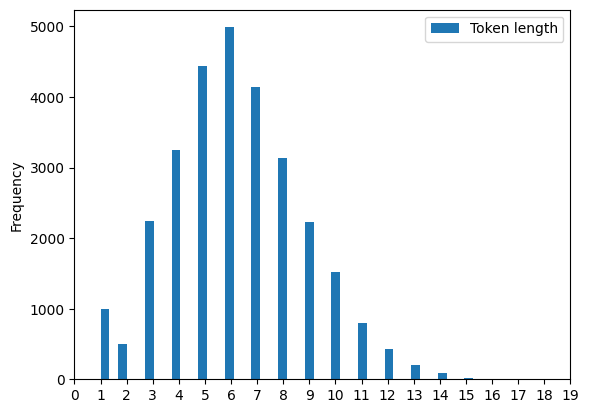

In [104]:
pd.DataFrame(map(len, wp_tokenizer.get_vocab()), columns = ['Token length']).plot.hist(bins = 50, xticks = list(range(20)))

In [151]:
output = wp_tokenizer.encode(text)
tokens = [t for t in output.tokens]
offsets = [output.offsets[i] for i in range(len(output))]
spans  = [text[s:e] for s, e in offsets]

list(zip(output.ids, tokens, spans))

[(101, '[CLS]', ''),
 (8667, 'Hello', 'Hello'),
 (117, ',', ','),
 (194, 'y', 'y'),
 (112, "'", "'"),
 (1155, 'all', 'all'),
 (106, '!', '!'),
 (1731, 'How', 'How'),
 (1132, 'are', 'are'),
 (1128, 'you', 'you'),
 (100, '[UNK]', '😁'),
 (136, '?', '?'),
 (146, 'I', 'I'),
 (8698, 'introduce', 'introduce'),
 (170, 'a', 'a'),
 (9225, 'triple', 'triple'),
 (2000, 'space', 'space'),
 (100, '[UNK]', '🤗'),
 (119, '.', '.'),
 (102, '[SEP]', '')]

In [152]:
wp_tokenizer.decode(output.ids)

"Hello, y ' all! How are you? I introduce a triple space."

# 3 Unigram

[Back to top](#plan)


[Unigram](https://huggingface.co/docs/transformers/tokenizer_summary#unigram) is a subword tokenization algorithm introduced in [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (Kudo, 2018)](https://arxiv.org/pdf/1804.10959.pdf). In contrast to BPE or WordPiece, Unigram initializes its base vocabulary to a large number of symbols and progressively trims down each symbol to obtain a smaller vocabulary. The base vocabulary could for instance correspond to all pre-tokenized words and the most common substrings. Unigram is not used directly for any of the models in the transformers, but it’s used in conjunction with SentencePiece.

At each training step, the Unigram algorithm defines a loss (often defined as the log-likelihood) over the training data given the current vocabulary and a unigram language model. Then, for each symbol in the vocabulary, the algorithm computes how much the overall loss would increase if the symbol was to be removed from the vocabulary. Unigram then removes p (with p usually being 10% or 20%) percent of the symbols whose loss increase is the lowest, i.e. those symbols that least affect the overall loss over the training data. This process is repeated until the vocabulary has reached the desired size. The Unigram algorithm always keeps the base characters so that any word can be tokenized.

Because Unigram is not based on merge rules (in contrast to BPE and WordPiece), the algorithm has several ways of tokenizing new text after training. So which one to choose? Unigram saves the probability of each token in the training corpus on top of saving the vocabulary so that the probability of each possible tokenization can be computed after training. The algorithm simply picks the most likely tokenization in practice, but also offers the possibility to sample a possible tokenization according to their probabilities.

In [137]:
uni_tokenizer = Tokenizer.from_pretrained('google-t5/t5-base')

type(uni_tokenizer.model)

tokenizers.models.Unigram

<Axes: ylabel='Frequency'>

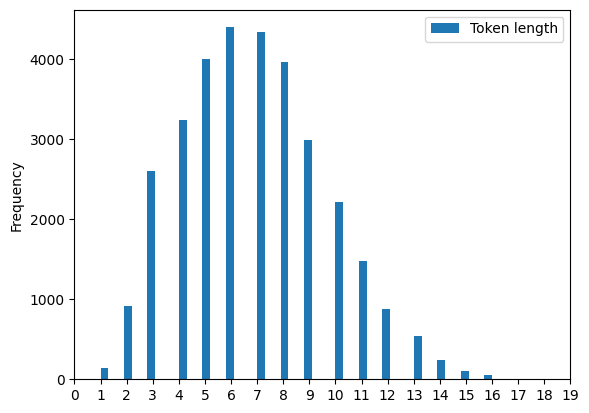

In [127]:
pd.DataFrame(map(len, uni_tokenizer.get_vocab()), columns = ['Token length']).plot.hist(bins = 50, xticks = list(range(20)))

In [153]:
output = uni_tokenizer.encode(text)
tokens = [t for t in output.tokens]
offsets = [output.offsets[i] for i in range(len(output))]
spans  = [text[s:e] for s, e in offsets]

list(zip(output.ids, tokens, spans))

[(8774, '▁Hello', 'Hello'),
 (6, ',', ','),
 (3, '▁', 'y'),
 (63, 'y', 'y'),
 (31, "'", "'"),
 (1748, 'all', 'all'),
 (55, '!', '!'),
 (571, '▁How', 'How'),
 (33, '▁are', 'are'),
 (25, '▁you', 'you'),
 (3, '▁', '😁'),
 (2, '😁', '😁'),
 (58, '?', '?'),
 (27, '▁I', 'I'),
 (4277, '▁introduce', 'introduce'),
 (3, '▁', 'a'),
 (9, 'a', 'a'),
 (12063, '▁triple', 'triple'),
 (628, '▁space', 'space'),
 (3, '▁', '🤗'),
 (2, '🤗', '🤗'),
 (5, '.', '.'),
 (1, '</s>', '')]

In [154]:
uni_tokenizer.decode(output.ids)

"Hello, y'all! How are you ? I introduce a triple space ."

### $\bullet$ GPT-2 tokenizer

Tokenizer based on a byte-level BPE tokenizer. The list of special tokens is determined by the [GPT2TokenizerFast](https://huggingface.co/transformers/_modules/transformers/models/gpt2/tokenization_gpt2_fast.html#GPT2TokenizerFast) class.

In [ ]:
path_to_vocab_gpt2 = os.path.join(path_to_save, 'gpt2', 'vocabulary')

In [96]:
# instantiate, fit and export GPT2 tokenizer
tokenizer_gpt2 = ByteLevelBPETokenizer()
tokenizer_gpt2.train(
    files = os.path.join(path_to_data, "news_auto_texts_trn.txt"), 
    vocab_size = 5000,
    special_tokens = ['<|endoftext|>'],
)
tokenizer_gpt2.save_model(path_to_vocab_gpt2)

['C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\news_auto\\gpt2\\vocabulary\\vocab.json',
 'C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\news_auto\\gpt2\\vocabulary\\merges.txt']

In [97]:
#re-import tokenizer into a more suitable class for model training
tokenizer_gpt2 = GPT2TokenizerFast.from_pretrained(path_to_vocab_gpt2, max_len = 512)

In [98]:
# "begin of word" is encoded by the special 'Ġ' character, see
# https://discuss.huggingface.co/t/bpe-tokenizers-and-spaces-before-words/475
txt = "Hello, y'all! How are you ?"
output = tokenizer_gpt2(txt)
tokens = output.tokens

print(txt)
print(tokens)

Hello, y'all! How are you ?
<bound method BatchEncoding.tokens of {'input_ids': [40, 457, 79, 12, 569, 7, 499, 1, 2604, 419, 817, 221, 31], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}>


### $\bullet$ Roberta tokenizer

Roberta tokenizer is a subclass of GPT2 tokenizer. The list of special tokens is determined by the [RobertaTokenizerFast](https://huggingface.co/transformers/_modules/transformers/models/roberta/tokenization_roberta_fast.html#RobertaTokenizerFast) class.

In [12]:
path_to_vocab_roberta = os.path.join(path_to_roberta, 'vocabulary')

In [20]:
# instantiate, fit and export Roberta tokenizer
vocab_size = 5000
special_tokens = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]

tokenizer_roberta = ByteLevelBPETokenizer()
tokenizer_roberta.train(
    files = os.path.join(path_to_data, "news_auto_texts_trn.txt"), 
    vocab_size = vocab_size,
    special_tokens = special_tokens,
)
tokenizer_roberta.save_model(path_to_vocab_roberta)

['C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\data\\vocab\\news_auto_roberta\\vocab.json',
 'C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\data\\vocab\\news_auto_roberta\\merges.txt']

In [13]:
#re-import tokenizer into a more suitable class for model training
tokenizer_roberta = RobertaTokenizerFast.from_pretrained(path_to_vocab_roberta, max_len = 512)

In [89]:
tokenizer_roberta.save_pretrained(os.path.join(path_to_roberta, "tokenizer"))

('C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\Tokenizer\\news_auto_roberta\\tokenizer_config.json',
 'C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\Tokenizer\\news_auto_roberta\\special_tokens_map.json',
 'C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\Tokenizer\\news_auto_roberta\\vocab.json',
 'C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\Tokenizer\\news_auto_roberta\\merges.txt',
 'C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\Tokenizer\\news_auto_roberta\\added_tokens.json')

In [14]:
txt = "Hello, y'all! How are you ?"
output = tokenizer_roberta(txt)
tokens = output.tokens

print(txt)
print(tokens)

Hello, y'all! How are you ?
<bound method BatchEncoding.tokens of {'input_ids': [0, 44, 461, 83, 16, 573, 11, 503, 5, 2608, 423, 821, 225, 35, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}>


### $\bullet$ Deberta-v2 tokenizer

Tokenizer based on _SentencePiece_. The list of special tokens is determined by the [DebertaV2Tokenizer](https://huggingface.co/transformers/_modules/transformers/models/deberta_v2/tokenization_deberta_v2.html#DebertaV2Tokenizer) class.

In [99]:
path_to_vocab_deberta_v2 = os.path.join(path_to_save, 'deberta_v2', 'vocabulary')

# instantiate, fit and export Deberta-v2 tokenizer
vocab_size = 5000
special_tokens = ["[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]"]

tokenizer_debertav2 = SentencePieceBPETokenizer()
tokenizer_debertav2.train(
    files = os.path.join(path_to_data, "news_auto_texts_trn.txt"), 
    vocab_size = vocab_size,
    special_tokens = special_tokens,
)
tokenizer_debertav2.save_model(path_to_vocab_deberta_v2)

['C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\news_auto\\deberta_v2\\vocabulary\\vocab.json',
 'C:\\Users\\Jb\\Desktop\\NLP\\BERTology\\saves\\news_auto\\deberta_v2\\vocabulary\\merges.txt']

In [14]:
# #re-import tokenizer into a more suitable class for model training
# not working_
# tokenizer_debertav2 = DebertaV2Tokenizer.from_pretrained(path_to_vocab_deberta_v2, max_len = 512)
# not working either
# tokenizer_debertav2 = DebertaV2Tokenizer(vocab_file = os.path.join(path_to_vocab_deberta_v2, 'vocab.json'))

### $\bullet$ Custom tokenizers

In [288]:
def fit_tokenizer(Model, Trainer, vocab_size, special_tokens):
    model = (
        Model(unk_token = "[UNK]")
        if 'unk_token' in inspect.signature(Model).parameters # for Unigram model
        else Model()
    )
    # instantiate tokenizer, and fit using external trainer
    tokenizer = Tokenizer(model)
    tokenizer.pre_tokenizer = Whitespace()
    trainer = Trainer(vocab_size = vocab_size, special_tokens = special_tokens)
    tokenizer.train(
        files = [os.path.join(path_to_data, "news_auto_texts_trn.txt")], 
        trainer = trainer,
    )
    return tokenizer

In [294]:
vocab_size = 5000
special_tokens = ["[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]"]

bpe_tokenizer = fit_tokenizer(BPE, BpeTrainer, vocab_size, special_tokens)
wdl_tokenizer = fit_tokenizer(WordLevel, WordLevelTrainer, vocab_size, special_tokens)
wdp_tokenizer = fit_tokenizer(WordPiece, WordPieceTrainer, vocab_size, special_tokens)
uni_tokenizer = fit_tokenizer(Unigram, UnigramTrainer, vocab_size, special_tokens)

In [295]:
path_to_bpe = os.path.join(path_to_data, 'vocab', 'news_auto_bpe.json')

# save
bpe_tokenizer.save(path_to_bpe, pretty = True)

# load as base Tokenizer
bpe_tokenizer = Tokenizer.from_file(path_to_bpe)

# load as tokenizer suitable for model training
tokenizer_bpe = PreTrainedTokenizerFast(tokenizer_file = path_to_bpe)

In [299]:
txt = "Hello, y'all! How are you 😁? wanna work at Toyota?"
output = tokenizer_bpe(txt)
tokens = output.tokens

print(txt)
print(tokens)

Hello, y'all! How are you 😁? wanna work at Toyota?
<bound method BatchEncoding.tokens of {'input_ids': [44, 1034, 1067, 16, 93, 11, 1121, 5, 2512, 1092, 1458, 0, 35, 91, 1287, 69, 1223, 1013, 4194, 35], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}>
